In [1]:
import json
import os
import pandas as pd

In [27]:
conala_file = "/home/v-haotiancui/NL2Code/Copilot-2/dataset/conala-corpus/conala-curated-all.json"
# read json file
with open(conala_file, "r") as f:
    data = json.load(f)
"""
[{'intent': 'How can I send a signal from a python program?',
  'rewritten_intent': 'send a signal `signal.SIGUSR1` to the current process',
  'snippet': 'os.kill(os.getpid(), signal.SIGUSR1)',
  'question_id': 15080500},
  ...
]
"""

"\n[{'intent': 'How can I send a signal from a python program?',\n  'rewritten_intent': 'send a signal `signal.SIGUSR1` to the current process',\n  'snippet': 'os.kill(os.getpid(), signal.SIGUSR1)',\n  'question_id': 15080500},\n  ...\n]\n"

In [28]:
conala_texts = []
for d in data:
    if d["rewritten_intent"]:
        intent = d["rewritten_intent"]
    else:
        if d["intent"]:
            intent = d["intent"]
        else:
            break
    if len(d["snippet"]) <= 0:
        break
    conala_texts.append(
        "# Python 3 \n"
        + d["snippet"]
        + '\n\n"""Explanation of what the code does: \n'
        + intent
        + '"""'
    )

In [29]:
len(conala_texts)

2879

# Generate the Annotated Explanation data

In [30]:
# the annotated explanations
raw_data_file = "/home/v-haotiancui/NL2Code/Copilot-2/dataset/ExplanationAnnotated.json"
with open(raw_data_file, "r") as f:
    data = json.load(f)
docstrings = []
codes = []
step1_scores = [int(d["step1"]) if len(d["step1"])>0 else 0 for d in data]

for i, s in enumerate(step1_scores):
    if s >= 2:
        docstrings.append(data[i]["docstring"])
        codes.append(data[i]["code"])

source_texts, target_texts = codes, docstrings

texts = []
for i in range(len(source_texts)):
    texts.append(
        "# Python 3 \n"
        + source_texts[i]
        + '\n\n"""Explanation of what the code does: \n'
        + target_texts[i]
        + '"""'
    )

In [31]:
# # the code-docstring data
# raw_data_file = "/home/v-haotiancui/NL2Code/Copilot-2/dataset/QualifiedExplanations.train.csv"
# df = pd.read_csv(raw_data_file)
# source_texts, target_texts = (
#     df["reference_code"].tolist(),
#     df["description"].tolist(),
# )

# texts = []
# for i in range(len(source_texts)):
#     texts.append(
#         "# Python 3 \n"
#         + source_texts[i]
#         + '\n\n"""Explanation of what the code does: \n'
#         + target_texts[i]
#         + '"""'
#     )

In [32]:
len(texts)

12455

In [33]:
# save jsonl file
data_file = "/home/v-haotiancui/NL2Code/Copilot-2/code2text/GPT-J/data/AnnotatedExplanations.train.jsonl"
if not os.path.exists(data_file):
    with open(data_file, "w") as f:
        for text in texts:
            f.write(json.dumps({"text": text}) + "\n")

# Append mode 2 data

mode 2 inference - prompt in few-shot learning setting to generate explanation for specific code blocks:
 
> xxx(code context), in the above code, how does the code block xxx (a block) works?   

In [33]:
# step2_scores = [int(d["step2"]) if len(d["step2"])>0 else 0 for d in data]
mode2_texts = []
for i, d in enumerate(data):
    if step1_scores[i] >=2 and len(d["match"]) > 0:
        code = d["code"]
        docstring = d["docstring"]
        for m in d["match"]:
            selected_code = m["selectedCode"]
            selected_doc = m["selectedDoc"]
            mode2_texts.append(
                "# Python 3 \n"
                + code
                + '\n\n"""in the above code, explain what the code block \n'
                + selected_code
                + '\n does: \n'
                + selected_doc
                + '"""'
            )

In [35]:
texts = texts + mode2_texts
len(texts)

17543

In [36]:
# save jsonl file
data_file = "/home/v-haotiancui/NL2Code/Copilot-2/code2text/GPT-J/data/AnnotatedExplanationsPlusMode2.train.jsonl"
if not os.path.exists(data_file):
    with open(data_file, "w") as f:
        for text in texts:
            f.write(json.dumps({"text": text}) + "\n")

# Explanation plus Conala

In [ ]:
texts = conala_texts + texts
len(texts)

In [ ]:
# # save jsonl file
# data_file = "/home/v-haotiancui/NL2Code/Copilot-2/code2text/GPT-J/data/ExpanationsPlusConala.train.jsonl"
# with open(data_file, "w") as f:
#     for text in texts:
#         f.write(json.dumps({"text": text}) + "\n")

In [ ]:
# save jsonl file
data_file = "/home/v-haotiancui/NL2Code/Copilot-2/code2text/GPT-J/data/AnnotatedExplanationsPlusConala.train.jsonl"
with open(data_file, "w") as f:
    for text in texts:
        f.write(json.dumps({"text": text}) + "\n")

# Process and add the APPS data

# [OPTIONAL] analyze the annotated explanation data

In [4]:
# the annotated explanations
raw_data_file = "/home/v-haotiancui/NL2Code/Copilot-2/dataset/ExplanationAnnotated.json"
with open(raw_data_file, "r") as f:
    data = json.load(f)

In [5]:
len(data)

13186

Text(0.5, 1.0, 'Histogram of step1 scores (general quality), avg=2.52')

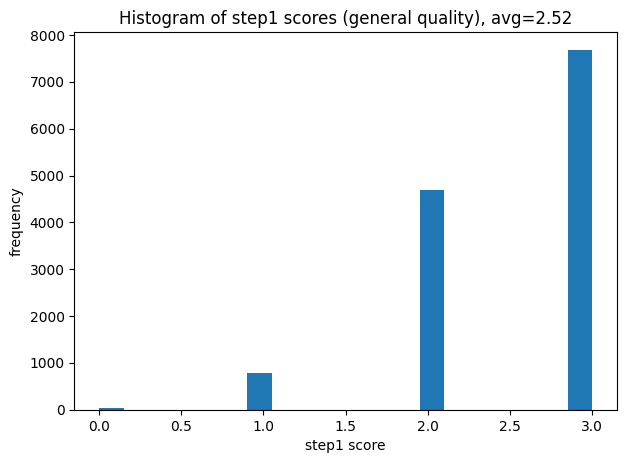

In [6]:
# show histogram of step1 scores
from matplotlib import pyplot as plt
step1_scores = [int(d["step1"]) if len(d["step1"])>0 else 0 for d in data]
avg_step1_score = sum(step1_scores) / len(step1_scores)
plt.figure(figsize=(7, 5), dpi=100)
plt.hist(step1_scores, bins=20)
plt.xlabel("step1 score")
plt.ylabel("frequency")
plt.title(f"Histogram of step1 scores (general quality), avg={avg_step1_score:.2f}")

Text(0.5, 1.0, 'Histogram of step2 scores (branch coverage), avg 1.41')

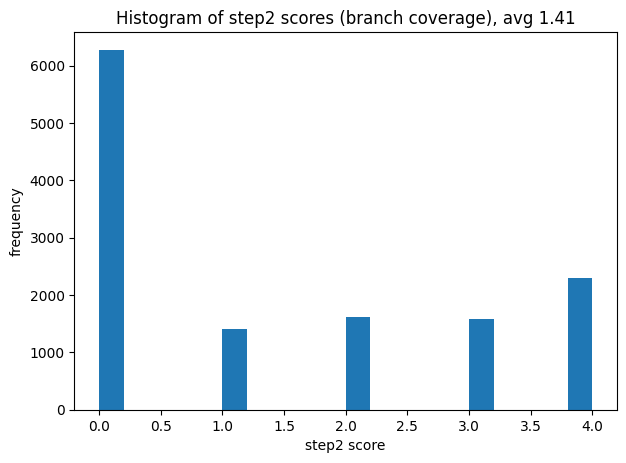

In [7]:
# show histogram of step2 scores
step2_scores = [int(d["step2"]) if len(d["step2"]) > 0 else 4 for d in data]
avg_step2_score = sum(step2_scores) / len(step2_scores)
plt.figure(figsize=(7, 5), dpi=100)
plt.hist(step2_scores, bins=20)
plt.xlabel("step2 score")
plt.ylabel("frequency")
plt.title(f"Histogram of step2 scores (branch coverage), avg {avg_step2_score:.2f}")

In [11]:
print(f"# of examples with step2 score >= 2: {sum(s >= 2 for s in step2_scores)}")
print(f'# of examples with step1 score >= 2: {sum(s >= 2 for s in step1_scores)}')

# of examples with step2 score >= 2: 5498
# of examples with step1 score >= 2: 12367


In [10]:
# show num of match
num_match = [len(d["match"]) for d in data]
avg_num_match = sum(num_match) / len(num_match)
print(f"avg num of match: {avg_num_match:.2f}")

# count non zero matches
non_zero_match = [n for n in num_match if n > 0]
print(f"count of non-zero match: {len(non_zero_match):.2f}")
print(f"avg num of non-zero match: {sum(non_zero_match) / len(non_zero_match):.2f}")


avg num of match: 0.56
count of non-zero match: 4619.00
avg num of non-zero match: 1.61


## save subset of the data
We filter the data to the subset of high quality examples, which have step1 scores > 1 and step2 scores > 1.

In [12]:
high_quality_data = []
for i,d in enumerate(data):
    if step1_scores[i] >= 2 and step2_scores[i] >= 2:
        high_quality_data.append(d)

len(high_quality_data)

5338

In [13]:
# save json file
output_file = "/home/v-haotiancui/NL2Code/Copilot-2/dataset/ExplanationAnnotatedHighQuality.json"
if not os.path.exists(output_file):
    with open(output_file, "w") as f:
        json.dump(high_quality_data, f)


## show top cases

In [24]:
# rank by step1 score
import numpy as np
step1_scores = np.array(step1_scores)
idx = step1_scores.argsort()[::-1]

In [25]:
max_data = data[idx[0]]
min_data = data[idx[-1]]

In [29]:
print(max_data["code"], "\n\ndocstring:\n", max_data["docstring"])

def context(style, after_reset=False): 
   initial_settings = mpl.rcParams.copy() 
   if after_reset: 
      mpl.rcdefaults() 
   try: 
      use(style) 
   except: 
      mpl.rcParams.update(initial_settings) 
      raise 
   else: 
      (yield) 
   finally: 
      mpl.rcParams.update(initial_settings) 

docstring:
 Context manager for using style settings temporarily. 
 Parameters 
 style : str, dict, or list 
 A style specification. Valid options are: 
 | str  | The name of a style or a path/URL to a style file. For a    | 
 |      | list of available style names, see `style.available`.       | 
 | dict | Dictionary with valid key/value pairs for                   | 
 |      | `matplotlib.rcParams`.                                      | 
 | list | A list of style specifiers (str or dict) applied from first | 
 |      | to last in the list.                                        | 
 after_reset : bool 
 If True, apply style after resetting settings to their defaults; 
 otherwise, a

In [31]:
print(min_data["code"], "\n\ndocstring:\n", min_data["docstring"])

def p_expression_binop(t): 
   if (t[2] == '+'): 
      t[0] = (t[1] + t[3]) 
   elif (t[2] == '-'): 
      t[0] = (t[1] - t[3]) 
   elif (t[2] == '*'): 
      t[0] = (t[1] * t[3]) 
   elif (t[2] == '/'): 
      t[0] = (t[1] / t[3]) 

docstring:
 expression : expression PLUS expression 
 expression MINUS expression 
 | expression TIMES expression 
 | expression DIVIDE expression
